In [1]:
from functions import *
from dataset import *

Using device: cuda
Dataset loaded from datasets/filteredDatasly1713.csv


# Dataset

In [2]:
datasetDF.head()

,p1,gamma1,gamma2,gamma3,ρ0,massa,raggio,Λns,cc
3,78.891199,2.627346,2.784976,3.772926,33.356865,0.201135,16.094220,15.318618,0.018459
4,78.891199,2.627346,2.784976,3.772926,33.386328,0.211048,15.600539,15.143554,0.019982
5,78.891199,2.627346,2.784976,3.772926,33.433083,0.227833,14.932901,14.727511,0.022535
6,78.891199,2.627346,2.784976,3.772926,33.499005,0.253756,14.178872,14.289953,0.026434
7,78.891199,2.627346,2.784976,3.772926,33.584297,0.291465,13.439770,13.617971,0.032032


In [3]:
datasetDF.shape

(14252, 9)

# Neural Network

In [4]:
class Encoder(nn.Module):
    def __init__(self,n,input_size):
        super(Encoder, self).__init__()

        self.inp = nn.Linear(input_size, 5*n)
        self.fc1 = nn.Linear(5*n, 4*n)
        self.fc2 = nn.Linear(4*n, 3*n)
        self.fc3 = nn.Linear (3*n, 2*n)
        self.fc4 = nn.Linear (2*n, 1*n)
        self.fc_latent = nn.Linear(1*n, 4)
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        dv1 = 0.
        dv2 = 0.
        dv3 = 0.
        x = self.inp(x)
        x = self.silu(x)
        x = self.fc1(x)
        x = self.silu(x)
        x = nn.functional.dropout(x, dv1, training=self.training)
        x = self.fc2(x)
        x = self.silu(x)
        x = nn.functional.dropout(x, dv2, training=self.training)
        x = self.fc3(x)
        x = self.silu(x)
        x = nn.functional.dropout(x, dv3, training=self.training)
        x = self.fc4(x)
        x = self.silu(x)
        latent = self.fc_latent(x)
        return latent

class Decoder(nn.Module):
    def __init__(self,n,input_size):
        super(Decoder, self).__init__()
        self.fc_latent = nn.Linear(4, 1*n)
        self.fc1 = nn.Linear(1*n, 2*n)
        self.fc2 = nn.Linear(2*n, 3*n)
        self.fc3 = nn.Linear(3*n, 4*n)
        self.fc4 = nn.Linear(4*n, 5*n)
        self.out = nn.Linear(5*n, input_size)
        self.silu = nn.SiLU()
        self.tanh = nn.Tanh()


    def forward(self, z):
        dv1 = 0.05
        dv2 = 0.05
        dv3 = 0.05
        z = self.silu(z)
        z = self.fc_latent(z)
        z = self.silu(z)
        z = self.fc1(z)
        z = self.silu(z)
        z = nn.functional.dropout(z, dv3, training=self.training)
        z = self.fc2(z)
        z = self.silu(z)
        z = nn.functional.dropout(z, dv2, training=self.training)
        z = self.fc3(z)
        z = self.silu(z)
        z = nn.functional.dropout(z, dv1, training=self.training)
        z = self.fc4(z)
        z = self.silu(z)
        reconstructed = self.out(z)
        return reconstructed

class Autoencoder(nn.Module):
    def __init__(self,n,input_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n,input_size)
        self.decoder = Decoder(n,input_size)

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed


## Loading the model

In [5]:
dir_name=os.getcwd()
base_filename='models/model_sz5000_b4_bl16_p50_a100_00_00_00_005_005_005'
PATH=os.path.join(dir_name, base_filename)

#model = torch.load(PATH,map_location=torch.device('cpu')).to(device) # Uncomment if using cpu instead of cuda
model = torch.load(PATH).to(device)

out_features = model.encoder.fc_latent.out_features

# MR and EoS predictions

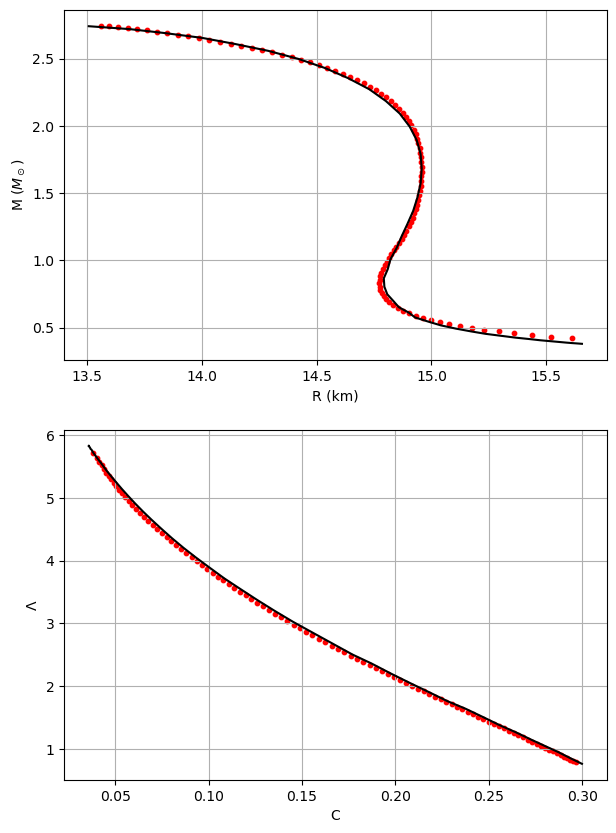

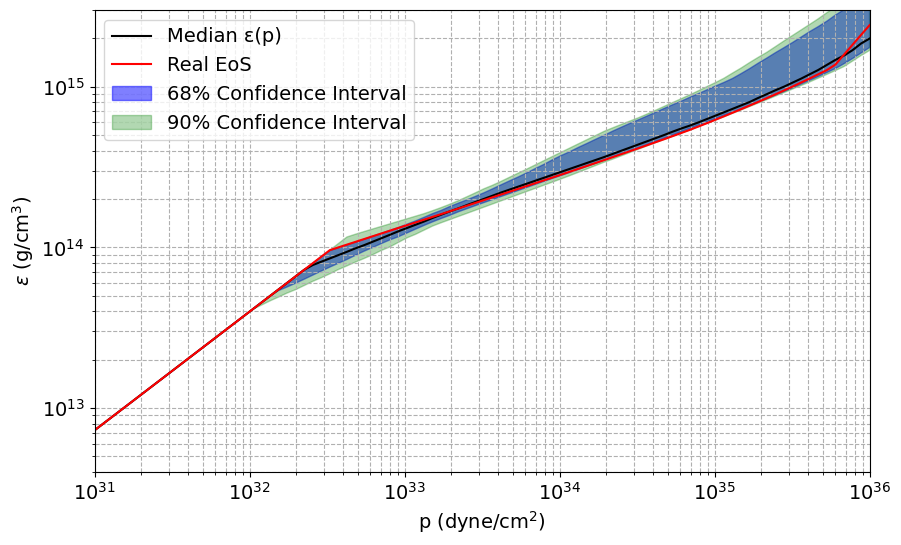

In [6]:
rho1l = 2.3e14
rho2l = 1e15

p1_c = 10**34.858 #MS1
g1_c = 3.224
g2_c = 3.033
g3_c = 1.325
mr_prediction(model, p1_c, g1_c, g2_c, g3_c, rho1l, rho2l, 0, "ms1") # Solves TOV
mrtabi = np.delete(np.array(process_eos(["label", p1_c, g1_c, g2_c, g3_c], 20, rho1l, rho2l))[:,4:9],2,axis=1) # TOV real solution
xx = gammas_from_mr(model, mrtabi,10) # Generate gammas from real TOV solution
_,_,_,_,_,_ = plot_eos_prediction(xx, p1_c, g1_c, g2_c, g3_c,0,"ms1") # Plots predicted EOS for xx distributions of gammas and plots expected one (p1_c, g1_c, g2_c, g3_c)

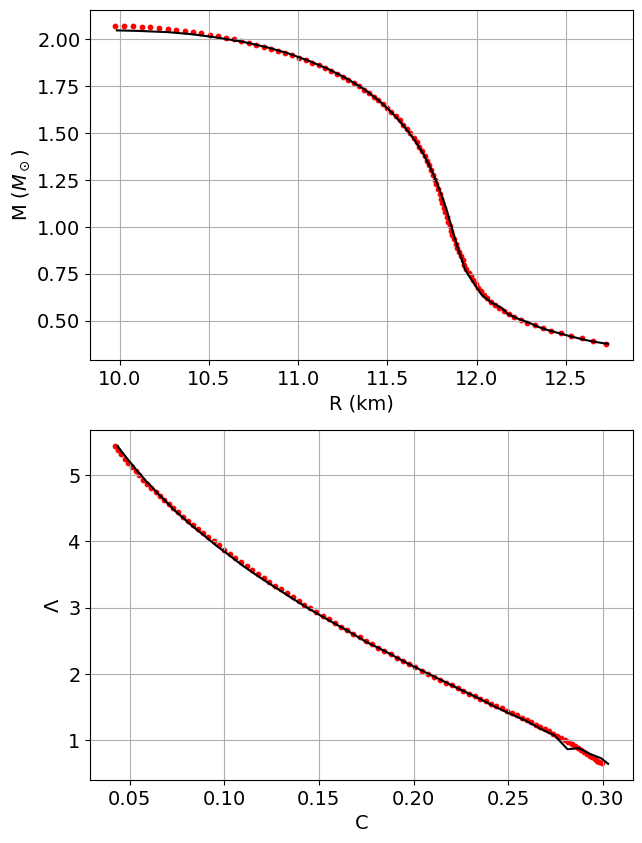

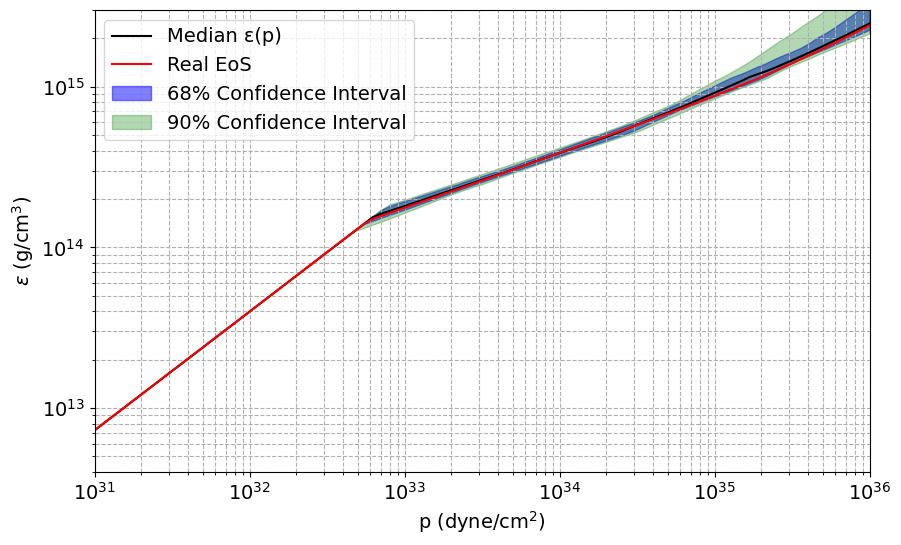

In [7]:
rho1l = 4e14
rho2l = 2e15

p1_c = 10**34.380 #SLY4
g1_c = 2.979
g2_c = 2.999
g3_c = 2.849
mr_prediction(model, p1_c, g1_c, g2_c, g3_c, rho1l, rho2l, 0, "sly4") 
mrtabi = np.delete(np.array(process_eos(["label", p1_c, g1_c, g2_c, g3_c], 20, rho1l, rho2l))[:,4:9],2,axis=1)
xx = gammas_from_mr(model, mrtabi,10)
_,_,_,_,_,_ = plot_eos_prediction(xx, p1_c, g1_c, g2_c, g3_c,0,"sly4") 

#### since WFF1 prediction is not precise we add random noise to MR$\Lambda$ data to check if the median get closer to the real EoS

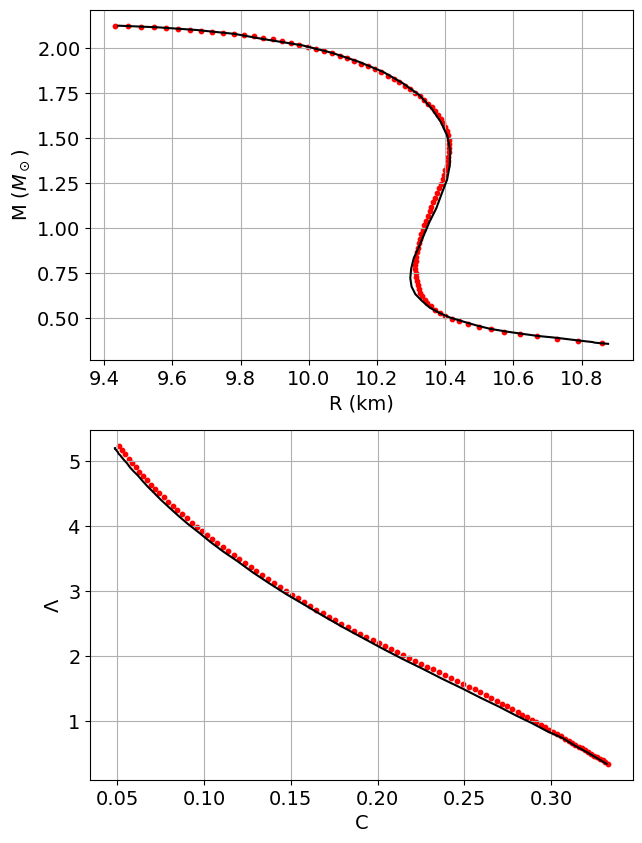

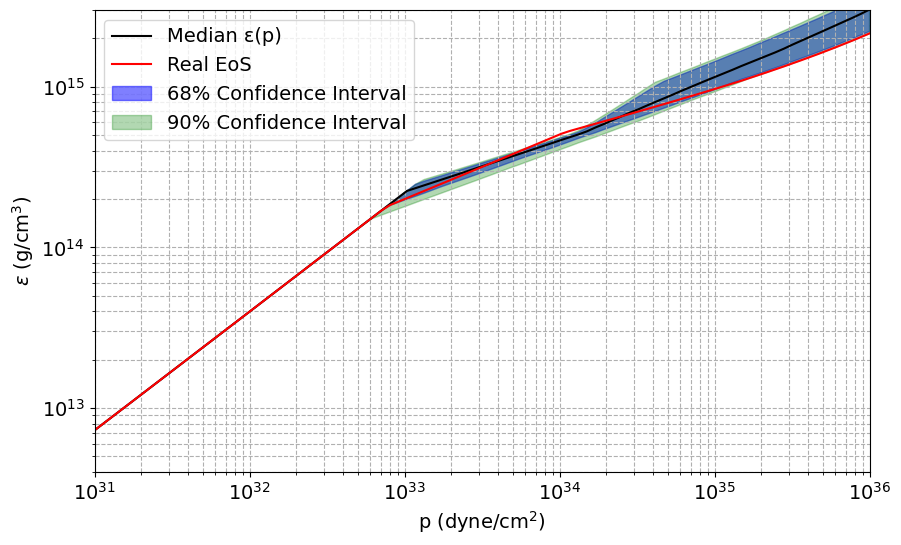

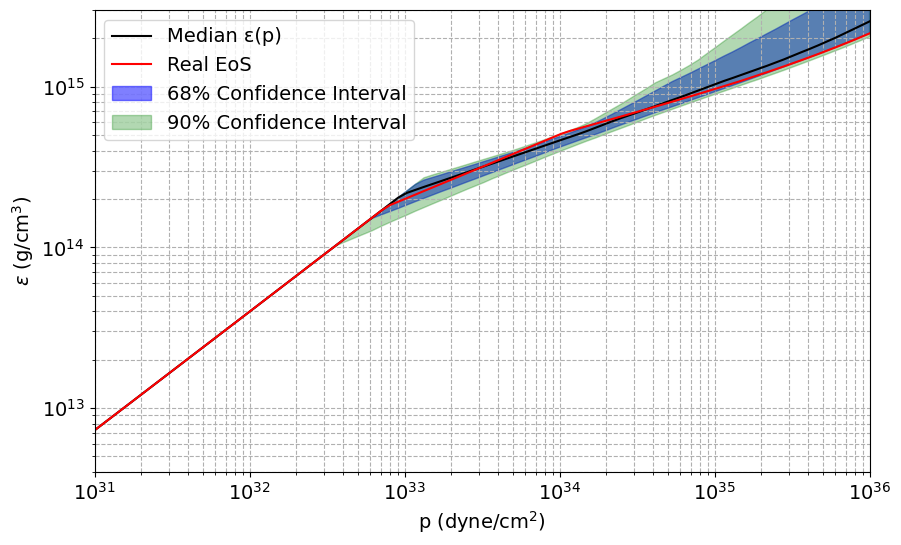

In [8]:
rho1l = 6e14
rho2l = 2e15
p1_c = 10**34.031 #WFF1
g1_c = 2.519
g2_c = 3.791
g3_c = 3.660
mr_prediction(model, p1_c, g1_c, g2_c, g3_c, rho1l, rho2l,0,"wff1")
mrtabi = np.delete(np.array(process_eos(["label", p1_c, g1_c, g2_c, g3_c], 20, rho1l, rho2l))[:,4:9],2,axis=1) 

#####################
# adding NOISE
#####################

mass = mrtabi[:, 0]
radius = mrtabi[:, 1]
lambdas = mrtabi[:, 2]
  # Number of errors to apply per point
num_errors_per_point = 5

new_data = []

for m, r, l in zip(mass, radius, lambdas):
    for _ in range(num_errors_per_point):
        mass_errors = np.random.uniform(-0.05, 0.05)
        radius_errors = np.random.uniform(-0.03, 0.03)
        lambdas_errors = np.random.uniform(-0.03, 0.03)

        mass_with_error = m * (1 + mass_errors)
        radius_with_error = r * (1 + radius_errors)
        lambdas_with_error = l * (1 + lambdas_errors)

        compactness = 1.47 * mass_with_error / radius_with_error
        new_data.append([mass_with_error, radius_with_error, lambdas_with_error, compactness])

# Convert new data to numpy array
new_mrtabi = np.array(new_data)

#####################
# END adding NOISE
#####################

xx = gammas_from_mr(model, mrtabi,20) 
p_values, median_eps_values, lower_16th, upper_84th, lower_5th, upper_95th = plot_eos_prediction(xx, p1_c, g1_c, g2_c, g3_c,0,"wff1") 

xx = gammas_from_mr(model, new_mrtabi,20)
p_values, median_eps_values, lower_16th, upper_84th, lower_5th, upper_95th = plot_eos_prediction(xx, p1_c, g1_c, g2_c, g3_c,0,"wff1_with_noise") 



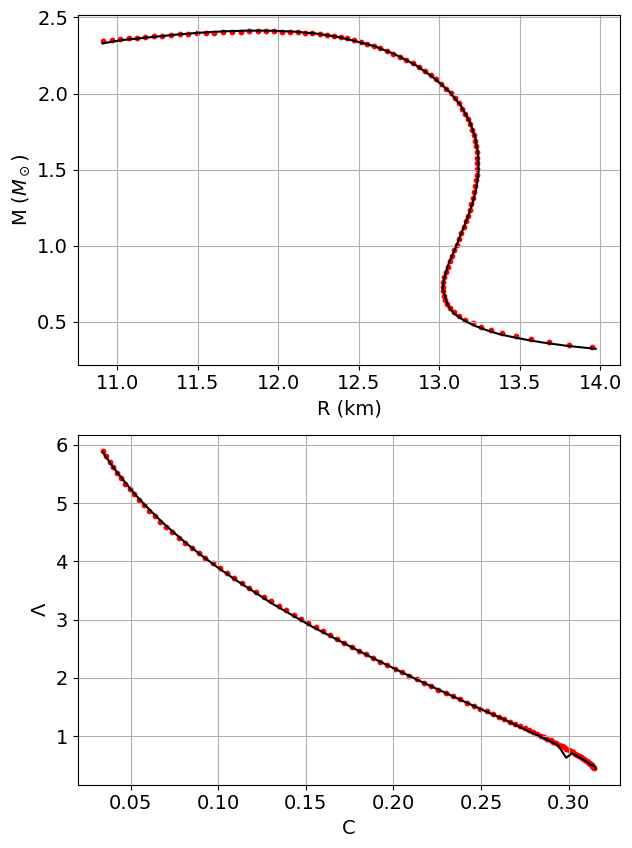

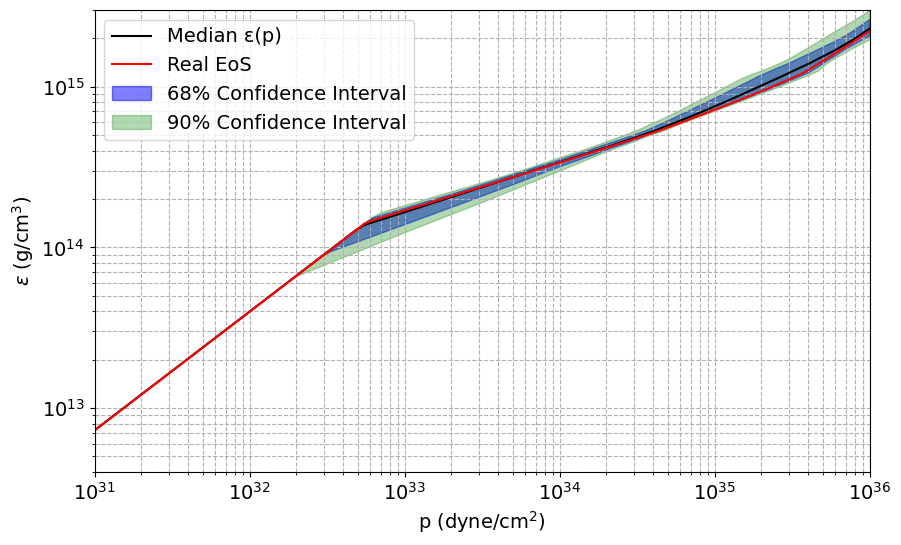

In [9]:
rho1l = 3e14
rho2l = 2e15
p1_c = 10**34.638 #DD2
g1_c = 3.414
g2_c = 3.097
g3_c = 2.322
mr_prediction(model, p1_c, g1_c, g2_c, g3_c, rho1l, rho2l,"dd2") 
mrtabi = np.delete(np.array(process_eos(["label", p1_c, g1_c, g2_c, g3_c], 20, rho1l, rho2l))[:,4:9],2,axis=1) # TOV real solution
xx = gammas_from_mr(model, mrtabi,10) 
_,_,_,_,_,_ = plot_eos_prediction(xx, p1_c, g1_c, g2_c, g3_c,"dd2")

# GW

In [10]:
file_path = 'eos_insensitive.dat'
file_path_pd = 'Pressure_density_credible_levels.dat.txt'

pddf = pd.read_csv(file_path_pd, sep=r'\s+',header=None ,comment='#', index_col = False)
gwdf = pd.read_csv(file_path, sep=r'\s+', comment='#',
                 names=['m1', 'm2', 'Lambda1', 'Lambda2', 'R1', 'R2'])
gwdf['Lambda1'] = gwdf['Lambda1'].apply(log)
gwdf['Lambda2'] = gwdf['Lambda2'].apply(log)
gwdf.head()

,m1,m2,Lambda1,Lambda2,R1,R2
0,1.543236,1.205749,4.575414,5.515609,10.730811,9.358211
1,1.482590,1.253115,2.979484,5.636506,8.186003,9.833989
2,1.541613,1.206940,3.450773,5.461760,9.149591,9.373914
3,1.562878,1.191476,3.903433,6.015381,9.951128,10.102846
4,1.656298,1.128266,3.312049,5.509105,9.602853,9.395534


In [11]:
pddf.head()

,0,1,2,3,4
0,14.0000,32.561779,32.562330,32.563101,32.563390
1,14.0152,32.587335,32.587378,32.587511,32.587637
2,14.0303,32.611438,32.611899,32.613190,32.614130
3,14.0455,32.635921,32.636741,32.639004,32.640570
4,14.0606,32.661113,32.662041,32.664467,32.666057


In [12]:
edengw = 10**torch.tensor(pddf.values).double()[:,0].numpy()
p5gw = 10**torch.tensor(pddf.values).double()[:,1].numpy()
p25gw = 10**torch.tensor(pddf.values).double()[:,2].numpy()
p75gw = 10**torch.tensor(pddf.values).double()[:,3].numpy()
p95gw = 10**torch.tensor(pddf.values).double()[:,4].numpy()

In [13]:
gwdf['C1'] = 1.47*gwdf['m1'] / gwdf['R2']
gwdf['C2'] = 1.47*gwdf['m2'] / gwdf['R2']

gwdf = gwdf[['m1', 'R1', 'Lambda1', 'C1',
         'm2', 'R2', 'Lambda2', 'C2']]




# This is not really used
stacked_gwdf = pd.DataFrame({
    'm': pd.concat([gwdf['m1'], gwdf['m2']], ignore_index=True),
    'R': pd.concat([gwdf['R1'], gwdf['R2']], ignore_index=True),
    'Lambda': pd.concat([gwdf['Lambda1'], gwdf['Lambda2']], ignore_index=True),
    'C': pd.concat([gwdf['C1'], gwdf['C2']], ignore_index=True)
})

gwdf1 = gwdf[['m1', 'R1', 'Lambda1', 'C1']]
gwdf2 = gwdf[['m2', 'R2', 'Lambda2', 'C2']]

length = len(torch.tensor(stacked_gwdf.values).double()[:,:])
mrdata = torch.tensor(stacked_gwdf.values).double()[:,:].numpy()
mrdata1 = torch.tensor(gwdf1.values).double()[:,:].numpy()
mrdata2 = torch.tensor(gwdf1.values).double()[:,:].numpy()


massPLOT = mrdata[:, 0]
radiusPLOT = mrdata[:, 1]

massPLOT1 = gwdf['m1'].values
radiusPLOT1 = gwdf['R1'].values
massPLOT2 = gwdf['m2'].values
radiusPLOT2 = gwdf['R2'].values

For each neutron star, the $\gamma$ ditributions are inferred using the function gammas_from_mr, which maps the MR$\Lambda$ ata mrdata1 and mrdata2 to the model's parameter space. Each dataset produces a sample of $\gamma$s stored in gamma_samples_star1 and gamma_samples_star2, respectively.

In [14]:
mc = 10 # Just 10 MC samples

xx_star1 = gammas_from_mr(model, mrdata1, mc)
gamma_samples_star1 = np.array(xx_star1)

xx_star2 = gammas_from_mr(model, mrdata2, mc)
gamma_samples_star2 = np.array(xx_star2)

To combine the $\gamma$-distributions inferred for the two neutron stars, kernel density estimation (KDE) is applied to the $\gamma$-samples from each star. The weights for each set of samples are computed based on the density estimated from the other star's distribution. Let $\mathbf{\gamma}_\mathrm{star1}$ and $\mathbf{\gamma}_\mathrm{star2}$ represent the $\gamma$-samples for star 1 and star 2, respectively. The KDE functions for the two distributions are defined as:

$
K_\mathrm{star1}(\mathbf{\gamma}) = \frac{1}{N_\mathrm{star1}} \sum_{i=1}^{N_\mathrm{star1}} \mathcal{K}(\mathbf{\gamma} - \mathbf{\gamma}_\mathrm{star1}^{(i)}),
$
$
K_\mathrm{star2}(\mathbf{\gamma}) = \frac{1}{N_\mathrm{star2}} \sum_{i=1}^{N_\mathrm{star2}} \mathcal{K}(\mathbf{\gamma} - \mathbf{\gamma}_\mathrm{star2}^{(i)}),
$

where $ \mathcal{K} $ is the kernel function and $ N_\mathrm{star1}, N_\mathrm{star2} $ are the number of samples for star 1 and star 2, respectively.

The weights for each sample are computed by evaluating the KDE of the other star's distribution:

$
w_\mathrm{star1}(\mathbf{\gamma}_\mathrm{star1}^{(i)}) = K_\mathrm{star2}(\mathbf{\gamma}_\mathrm{star1}^{(i)}), \quad
w_\mathrm{star2}(\mathbf{\gamma}_\mathrm{star2}^{(i)}) = K_\mathrm{star1}(\mathbf{\gamma}_\mathrm{star2}^{(i)}).
$


In [15]:
kde_star1 = gaussian_kde(gamma_samples_star1.T)
kde_star2 = gaussian_kde(gamma_samples_star2.T)

weights_star1 = kde_star2(gamma_samples_star1.T)
weights_star2 = kde_star1(gamma_samples_star2.T)

The samples from both neutron stars are merged into a single combined distribution. Let $\mathbf{\gamma}_\mathrm{combined}$ represent the combined samples, and $w_\mathrm{combined}$ the corresponding weights. These are computed as:

$
\mathbf{\gamma}_\mathrm{combined} = \{\mathbf{\gamma}_\mathrm{star1}, \mathbf{\gamma}_\mathrm{star2}\},
$
$
w_\mathrm{combined} = \{w_\mathrm{star1}, w_\mathrm{star2}\}, \quad \text{normalized as: } \sum w_\mathrm{combined} = 1.
$

The normalization ensures that the combined weights sum to unity, allowing the construction of a unified posterior distribution of the $\gamma$-parameters.


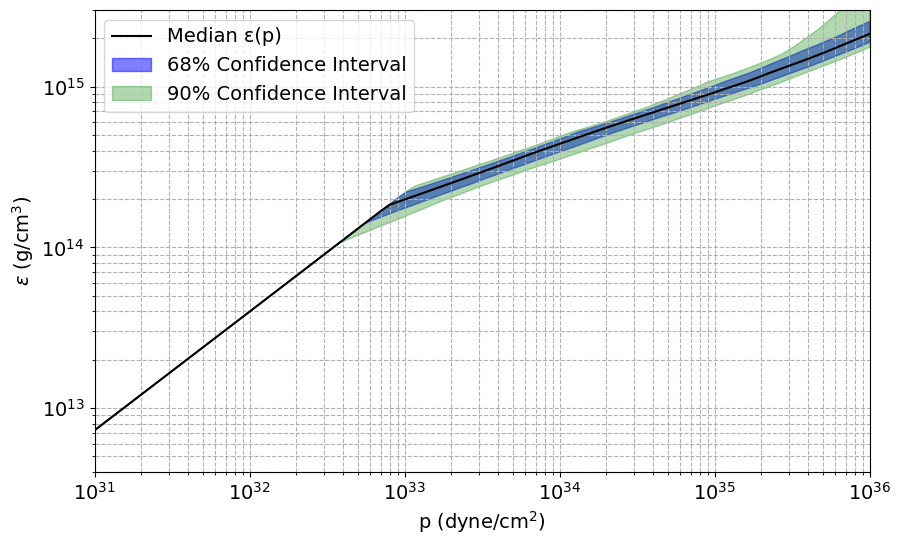

In [16]:
combined_samples = np.vstack((gamma_samples_star1, gamma_samples_star2))
combined_weights = np.concatenate((weights_star1, weights_star2))
combined_weights /= np.sum(combined_weights)

#### Resample
num_samples = 1000
sample_indices = np.random.choice(len(combined_samples), size=num_samples, p=combined_weights)
resampled_combined_samples = combined_samples[sample_indices]

p_values, median_eps_values, lower_16th, upper_84th, lower_5th, upper_95th = plot_eos_prediction(
resampled_combined_samples, 0, 0, 0, 0, 0 , "")

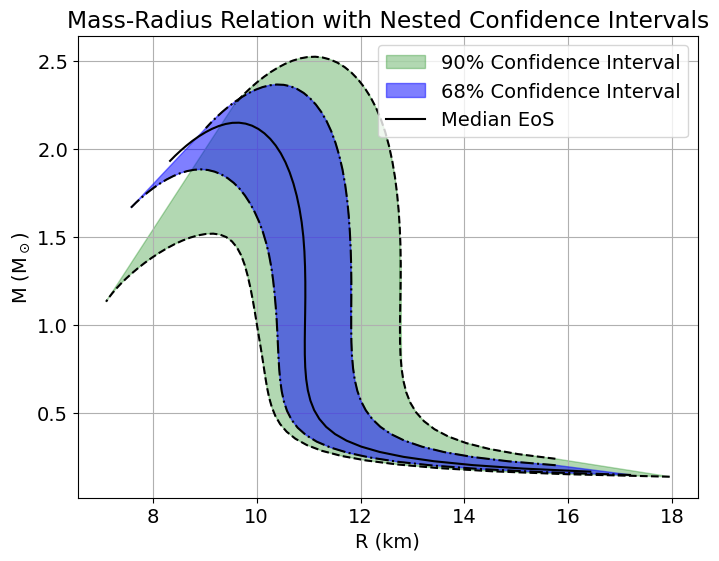

In [17]:
MR_data = mr_pred_from_eos_pred(p_values, median_eps_values, lower_16th, upper_84th, lower_5th, upper_95th)

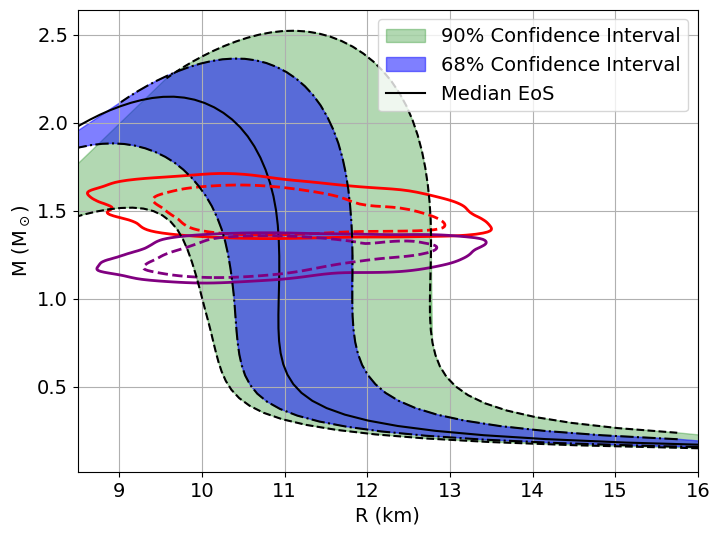

In [18]:
# Build KDE for component 1
data1 = np.vstack([massPLOT1, radiusPLOT1])
kde1 = gaussian_kde(data1)

mass_min1, mass_max1 = massPLOT1.min(), massPLOT1.max()
radius_min1, radius_max1 = radiusPLOT1.min(), radiusPLOT1.max()

mass_grid1, radius_grid1 = np.mgrid[
    mass_min1 - 0.1 : mass_max1 + 0.1 : 100j,
    radius_min1 - 0.1 : radius_max1 + 0.1 : 100j
]

positions1 = np.vstack([mass_grid1.ravel(), radius_grid1.ravel()])
kde_values1 = kde1(positions1).reshape(mass_grid1.shape)

# Compute confidence levels for component 1
kde_values_flat1 = kde_values1.ravel()
indices1 = np.argsort(kde_values_flat1)
kde_values_sorted1 = kde_values_flat1[indices1]
cumulative_density1 = np.cumsum(kde_values_sorted1)
cumulative_density1 /= cumulative_density1[-1]

confidence_levels = [0.10, 0.32]  # 90% and 68% from the top (or vice-versa)
inv_cdf1 = interp1d(cumulative_density1, kde_values_sorted1,
                    bounds_error=False,
                    fill_value=(kde_values_sorted1[0], kde_values_sorted1[-1]))
levels1 = inv_cdf1(confidence_levels)

# Build KDE for component 2
data2 = np.vstack([massPLOT2, radiusPLOT2])
kde2 = gaussian_kde(data2)

mass_min2, mass_max2 = massPLOT2.min(), massPLOT2.max()
radius_min2, radius_max2 = radiusPLOT2.min(), radiusPLOT2.max()

mass_grid2, radius_grid2 = np.mgrid[
    mass_min2 - 0.1 : mass_max2 + 0.1 : 100j,
    radius_min2 - 0.1 : radius_max2 + 0.1 : 100j
]

positions2 = np.vstack([mass_grid2.ravel(), radius_grid2.ravel()])
kde_values2 = kde2(positions2).reshape(mass_grid2.shape)

# Compute confidence levels for component 2
kde_values_flat2 = kde_values2.ravel()
indices2 = np.argsort(kde_values_flat2)
kde_values_sorted2 = kde_values_flat2[indices2]
cumulative_density2 = np.cumsum(kde_values_sorted2)
cumulative_density2 /= cumulative_density2[-1]

inv_cdf2 = interp1d(cumulative_density2, kde_values_sorted2,
                    bounds_error=False,
                    fill_value=(kde_values_sorted2[0], kde_values_sorted2[-1]))
levels2 = inv_cdf2(confidence_levels)


plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

def fill_confidence_region(
    R_lower, M_lower, R_upper, M_upper,
    color, alpha, label
):
    """
    Fill region between two curves in (R, M) space.
    We build a polygon by going up the lower curve
    and down the upper curve in R.
    """
    # Sort each curve by R
    idx_l = np.argsort(R_lower)
    Rl = R_lower[idx_l]
    Ml = M_lower[idx_l]

    idx_u = np.argsort(R_upper)
    Ru = R_upper[idx_u]
    Mu = M_upper[idx_u]

    # Polygon by concatenating lower-curve forward, upper-curve reversed
    R_polygon = np.concatenate([Rl, Ru[::-1]])
    M_polygon = np.concatenate([Ml, Mu[::-1]])

    plt.fill(R_polygon, M_polygon, color=color, alpha=alpha, label=label)

# 1) Fill 90% first (outer band)
fill_confidence_region(
    MR_data['lower_90']['R'], MR_data['lower_90']['M'],
    MR_data['upper_90']['R'], MR_data['upper_90']['M'],
    color='green', alpha=0.3, label='90% Confidence Interval'
)

# 2) Fill 68% next (inner band)
fill_confidence_region(
    MR_data['lower_68']['R'], MR_data['lower_68']['M'],
    MR_data['upper_68']['R'], MR_data['upper_68']['M'],
    color='blue', alpha=0.5, label='68% Confidence Interval'
)

# 3) Median curve
plt.plot(MR_data['median']['R'], MR_data['median']['M'],
         '-k', label='Median EoS')

plt.plot(
    MR_data['lower_68']['R'], MR_data['lower_68']['M'],
    '-.k', zorder=3
)
plt.plot(
    MR_data['upper_68']['R'], MR_data['upper_68']['M'],
    '-.k', zorder=3
)
plt.plot(
    MR_data['lower_90']['R'], MR_data['lower_90']['M'],
    '--k', zorder=3
)
plt.plot(
    MR_data['upper_90']['R'], MR_data['upper_90']['M'],
    '--k', zorder=3
)

# --- (B) Plot the contours for each GW170817 component ---

# NOTE: your grids are defined as mass_grid vs radius_grid, but
# we want R on the x-axis and M on the y-axis.
# That means:
#   x = radius_grid
#   y = mass_grid
# For the contour calls, we pass in x first, y second, then z.

CS1 = plt.contour(
    radius_grid1,   # x
    mass_grid1,     # y
    kde_values1,    # z
    levels=levels1,
    colors='red',
    linestyles=['-', '--'],  # first contour is 68%, second is 90% or vice versa
    linewidths=[2, 2]
)

CS2 = plt.contour(
    radius_grid2,   # x
    mass_grid2,     # y
    kde_values2,    # z
    levels=levels2,
    colors='purple',
    linestyles=['-', '--'],
    linewidths=[2, 2]
)

# Label the contours (uncomment if you want inline labels)
fmt1 = {}
strs = ['68%', '90%']
for level, s in zip(CS1.levels, strs):
    fmt1[level] = s + ' Comp1'
# plt.clabel(CS1, CS1.levels, inline=True, fmt=fmt1, fontsize=10)

fmt2 = {}
for level, s in zip(CS2.levels, strs):
    fmt2[level] = s + ' Comp2'
# plt.clabel(CS2, CS2.levels, inline=True, fmt=fmt2, fontsize=10)

# --- (C) Final touches ---
plt.xlabel('R (km)')
plt.ylabel(r'M (M$_\odot$)')
plt.grid(True)
plt.xlim(8.5, 16)
plt.legend(loc='upper right')

plt.show()

# Comparison with LV EoS

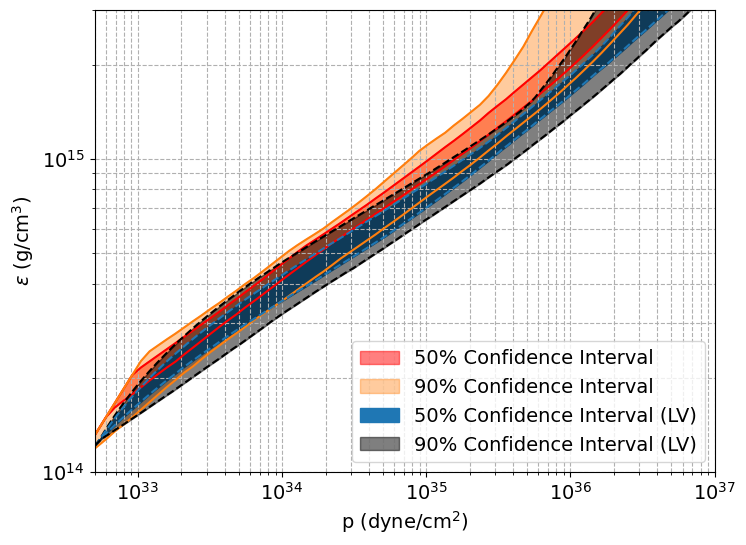

In [19]:
p_log_values = np.linspace(25, 37, 200)
p_values = 10 ** p_log_values

if (p1_c != 0 and g1_c != 0 and g2_c != 0 and g3_c != 0):
    eps_values_real = [
        epsOfP(p / Psol, p1_c / Psol, g1_c, g2_c, g3_c) * rhosol
        for p in p_values
    ]

median_eps_values = []
lower_25th = []
upper_75th = []
lower_5th = []
upper_95th = []

positive_yy = resampled_combined_samples
    
for p in p_values:
    eps_values = []
    for i in range(len(positive_yy)):
        try:
            p1 = np.exp(positive_yy[i][0]) / Psol
            gamma1 = positive_yy[i][1]
            gamma2 = positive_yy[i][2]
            gamma3 = positive_yy[i][3]
            eps = epsOfP(p / Psol, p1, gamma1, gamma2, gamma3) * Density

            # Avoid invalid or extreme values
            if not np.isnan(eps) and np.isfinite(eps) and eps > 0:
                eps_values.append(eps)
        except (OverflowError, ValueError, RuntimeWarning):
            # Skip problematic points
            continue

    if eps_values:  # Ensure there are valid points
        log_eps_values = np.log10(eps_values)
        median_log_eps = np.median(log_eps_values)
        lower_25th_log_eps = np.percentile(log_eps_values, 25)
        upper_75th_log_eps = np.percentile(log_eps_values, 75)
        lower_5th_log_eps = np.percentile(log_eps_values, 5)
        upper_95th_log_eps = np.percentile(log_eps_values, 95)

        median_eps_values.append(10 ** median_log_eps)
        lower_25th.append(10 ** lower_25th_log_eps)
        upper_75th.append(10 ** upper_75th_log_eps)
        lower_5th.append(10 ** lower_5th_log_eps)
        upper_95th.append(10 ** upper_95th_log_eps)
    else:
        median_eps_values.append(np.nan)
        lower_16th.append(np.nan)
        upper_84th.append(np.nan)
        lower_5th.append(np.nan)
        upper_95th.append(np.nan)


p_values = np.array(p_values)
median_eps_values = np.array(median_eps_values)
lower_25th = np.array(lower_25th)
upper_75th = np.array(upper_75th)
lower_5th = np.array(lower_5th)
upper_95th = np.array(upper_95th)


if (p1_c != 0 and g1_c != 0 and g2_c != 0 and g3_c != 0):
    eps_values_real = np.array(eps_values_real)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})


plt.loglog(p_values, lower_5th, color='tab:orange')
plt.loglog(p_values, lower_25th, color='red')
plt.loglog(p_values, upper_75th, color='red')
plt.loglog(p_values, upper_95th, color='tab:orange')

# Fill between the 25th and 75th percentiles (approximate 50% confidence interval)
plt.fill_between(
    p_values,
    lower_25th,
    upper_75th,
    color='red',
    alpha=0.5,
    label='50% Confidence Interval'
)

# Fill between the 5th and 95th percentiles (approximate 90% confidence interval)
plt.fill_between(
    p_values,
    lower_5th,
    upper_95th,
    color='tab:orange',
    alpha=0.4,
    label='90% Confidence Interval'
)




plt.loglog(p5gw, edengw, color='black',ls='--')
plt.loglog(p25gw, edengw, color='tab:blue',ls='--')
plt.loglog(p75gw, edengw, color='tab:blue',ls='--')
plt.loglog(p95gw, edengw, color='black',ls='--')

plt.fill_betweenx(
    edengw,
    p25gw,
    p75gw,
    color='tab:blue',
    alpha=1,
    label='50% Confidence Interval (LV)'
)
plt.fill_betweenx(
    edengw,
    p5gw,
    p95gw,
    color='black',
    alpha=0.5,
    label='90% Confidence Interval (LV)'
)


plt.xlabel(r'p (dyne/cm$^2$)')
plt.ylabel(r'$\epsilon$ (g/cm$^3$)')
plt.grid(True, which="both", ls="--")
plt.xlim(5e32, 1e37)
plt.ylim(1e14, 3e15)
plt.legend()
plt.show()